# **Preprocessing of Reddit Data**

## **Package Imports**

In [1]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (792 kB)


In [2]:
import numpy as np 
import pandas as pd 
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
import matplotlib.pyplot as plt
import zipfile

## **Set file paths**

In [27]:
# reddit data

Ask_Pol_path = "../data/new_preprocessing/Ask_Politics_new_preprocessing_com_rep.csv"
Askpol_path = "../data/new_preprocessing/Askpolitics_new_preprocessing_com_rep.csv"
PolDis_path = "../data/new_preprocessing/PoliticalDiscussion_new_preprocessing_com_rep.csv"
PolDeb_path = "../data/new_preprocessing/PoliticalDebate_new_preprocessing_com_rep.csv"
NeuPol_path = "../data/new_preprocessing/NeutralPolitics_new_preprocessing_com_rep.csv"

pol_path = "../data/new_preprocessing/splitted_politics_data.zip"

# nltk path
nltk_data_path = 'nltk_data'

# output
csv_output_path = "preprocess_outputs/tokens_reddit.csv"
txt_output_path = 'preprocess_outputs/tokens_reddit.txt'
json_output_path = 'preprocess_outputs/tokens_reddit.json'

# cleaned tokens


full_output_path = 'preprocess_outputs/reddit_full.csv'

In [52]:
# import data
Ask_Politics = pd.read_csv(Ask_Pol_path)
Askpolitics = pd.read_csv(Askpol_path)
PoliticalDiscussion = pd.read_csv(PolDis_path)
PoliticalDebate = pd.read_csv(PolDeb_path)
NeutralPolitics = pd.read_csv(NeuPol_path)

# politics from zip files
df_chunks = []
with zipfile.ZipFile(pol_path, 'r') as zf:
    file_list = zf.namelist()  # Get all file names in ZIP

    # Sort to maintain order (if needed)
    file_list.sort()  

    print("Files found in ZIP:", file_list)  # Debugging step

    for file in file_list:
        with zf.open(file) as f:
            df_chunk = pd.read_csv(f,  quotechar='"', encoding="utf-8")  
            df_chunks.append(df_chunk)  # Store the chunk


politics = pd.concat(df_chunks, ignore_index=True)

print(f"Successfully loaded {len(politics)} rows from {pol_path}")

Files found in ZIP: ['data_part_1.csv', 'data_part_2.csv', 'data_part_3.csv', 'data_part_4.csv', 'data_part_5.csv']
Successfully loaded 4175294 rows from ../data/new_preprocessing/splitted_politics_data.zip


## **Checks**

* subreddit column with subreddit name
* remove unnecessary columns

In [53]:
cols_to_select = ['msg_id_parent', 'msg_id_child', 'submission_id',
                 'subreddit',
                 'body_child', 'body_parent', 'submission_text',
                 'exact_time_child', 
                 'author_child', 'author_parent', 'author_submission']

In [54]:
df_dict = {
    'Ask_Politics' : Ask_Politics,
    'Askpolitics' : Askpolitics,
    'PoliticalDiscussion' : PoliticalDiscussion,
    'PoliticalDebate' : PoliticalDebate,
    'NeutralPolitics' : NeutralPolitics,
    'politics' : politics 
    
}

subreddits = ['Ask_Politics' , 'Askpolitics', 'PoliticalDiscussion', 'PoliticalDebate', 'NeutralPolitics','politics']


In [55]:
# remove quoatation marks from politics and Pol Disc.

for subr in ["politics", "PoliticalDiscussion"]:
    for col in ['msg_id_parent', 'msg_id_child', 'submission_id',
                'subreddit', 
                'body_child', 'body_parent', 'submission_text',
                'author_child', 'author_parent', 'author_submission']:
        if df_dict[subr][col].dtype == "object":  # Apply only to string columns
            df_dict[subr][col] = df_dict[subr][col].str.strip('"')



In [56]:
df_dict['Ask_Politics']

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7ecp8d,c7ecs2n,Ted Olson and David Boies are extremely good ...,Ask_Politics,1.355167e+09,karmanaut,4.0,4,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
1,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5,0.0,14m325,...,Ramblin_Dash,7.0,7,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0,1.355161e+09
2,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,1.355170e+09,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,1.355170e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
3,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,1.355171e+09,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
4,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,1.355171e+09,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54257,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,1.701905e+09,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,1.552664e+09,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,1.552662e+09
54258,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,1.702175e+09,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,1.580156e+09,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,1.580084e+09
54259,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,1.702416e+09,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,1.688412e+09,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,1.688317e+09
54260,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,1.702431e+09,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,1.550918e+09,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,1.550913e+09


# **Investigate Text Length**

## Length, as the LLMs get them

In [57]:
def add_len(df):
    
    df['len_parent'] = df['body_parent'].apply(lambda x: len(x.split()))
    df['len_child'] = df['body_child'].apply(lambda x: len(x.split()))
    df['len_submission'] = df['submission_text'].apply(lambda x: len(x.split()))



In [58]:
for subr in subreddits:
    print(subr)

    add_len(df_dict[subr])

Ask_Politics
Askpolitics
PoliticalDiscussion
PoliticalDebate
NeutralPolitics
politics


In [59]:
df_dict['Ask_Politics'][['body_parent', 'len_parent']]

,body_parent,len_parent
0,Regarding Perry vs. Brown the current name of ...,123
1,Regarding Perry vs. Brown the current name of ...,123
2,So what was wrong with or ?,7
3,We will be adhering to the AskScience style of...,13
4,We will be adhering to the AskScience style of...,13
...,...,...
54257,"Despite how many people communism has killed, ...",97
54258,Here are some pretty good Conservative voices ...,86
54259,A lot of the replies here are not describing t...,244
54260,1. Most liberal intellectuals have better thin...,678


In [60]:
reddit_df_OG = pd.concat([df_dict['Ask_Politics'], df_dict['Askpolitics'], df_dict['PoliticalDebate'], df_dict['PoliticalDiscussion'],
                       df_dict['NeutralPolitics'], df_dict['politics']]).reset_index(drop = True)
reddit_df_OG

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission,len_parent,len_child,len_submission
0,c7ecp8d,c7ecs2n,Ted Olson and David Boies are extremely good ...,Ask_Politics,1.355167e+09,karmanaut,4.0,4.0,0.0,14m325,...,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0.0,1.355161e+09,123,79,20
1,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5.0,0.0,14m325,...,0.0,1.355166e+09,"1 regarding DOMA, and the 2nd regarding Califo...",karmanaut,0.0,0.0,1.355161e+09,123,52,20
2,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,1.355170e+09,karmanaut,5.0,5.0,0.0,14m26x,...,0.0,1.355170e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9.0,1.355160e+09,7,81,137
3,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,1.355171e+09,TehNoff,3.0,3.0,0.0,14m26x,...,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9.0,1.355160e+09,13,29,137
4,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,1.355171e+09,karmanaut,1.0,1.0,0.0,14m26x,...,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9.0,1.355160e+09,13,64,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958018,kfkh5ib,kfmd52k,Fact-checking doesnt work if no one hears you ...,politics,1.703978e+09,Knightforlife,NaN,NaN,NaN,18uirzt,...,NaN,1.703953e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,NaN,NaN,1.703952e+09,8,13,100
4958019,kfklsb6,kforzbx,This is such a spot on interpretation of what'...,politics,1.704023e+09,bakerfredricka,NaN,NaN,NaN,18uirzt,...,NaN,1.703954e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,NaN,NaN,1.703952e+09,8,12,100
4958020,kfmq5kr,kfp6tzv,Voting is not nearly that simple. In a first p...,politics,1.704032e+09,glassjar1,NaN,NaN,NaN,18uirzt,...,NaN,1.703983e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,NaN,NaN,1.703952e+09,6,290,100
4958021,kfp3d4v,kfp8xh8,"also, try explaining why biden is better to a ...",politics,1.704033e+09,HaulinBoats,NaN,NaN,NaN,18uirzt,...,NaN,1.704030e+09,"It's Saturday, folks. Let's all kick back with...",optimalg,NaN,NaN,1.703952e+09,8,23,100


In [61]:
parents_OG = reddit_df_OG[['msg_id_parent', 'len_parent']].drop_duplicates(subset = "msg_id_parent")
child_OG = reddit_df_OG[['msg_id_child', 'len_child']].drop_duplicates(subset = "msg_id_child")
submissions_OG = reddit_df_OG[['submission_id', 'len_submission']].drop_duplicates(subset = "submission_id")


len(parents_OG) + len(submissions_OG) +len(child_OG)

7042296

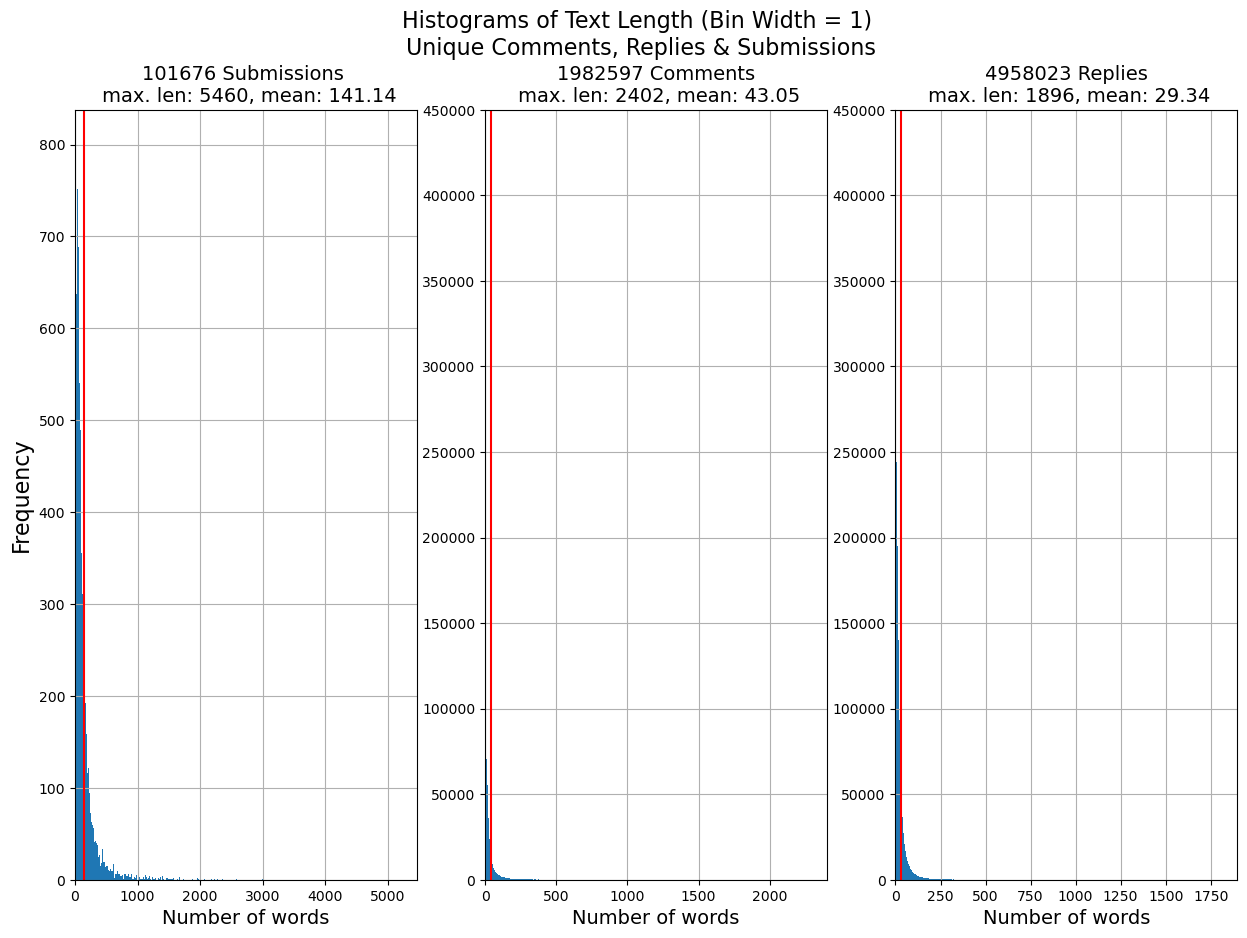

In [62]:


parents_here = parents_OG
child_here = child_OG
submission_here = submissions_OG


fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
fig.suptitle(f"Histograms of Text Length (Bin Width = 1)\n Unique Comments, Replies & Submissions", fontsize=16)

bin_edges = np.arange(0, max(parents_here['len_parent'].max(), 
                                  child_here['len_child'].max(), 
                                  submission_here['len_submission'].max()) + 1, 1)

axes[0].hist(submission_here['len_submission'], bins=bin_edges)
axes[0].axvline(x = submission_here['len_submission'].mean(), color = "red")
axes[0].set_xlim(0, submission_here['len_submission'].max() + 2)
axes[0].set_title(f"{len(submission_here)} Submissions \n max. len: {submission_here['len_submission'].max()}, mean: {round(submission_here['len_submission'].mean(), 2)}", fontsize = 14)
axes[0].set_xlabel("Number of words", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=16)
axes[0].grid(True)

axes[1].hist(parents_here['len_parent'], bins=bin_edges)
axes[1].axvline(x = parents_here['len_parent'].mean(), color = "red")
axes[1].set_xlim(0, parents_here['len_parent'].max() + 2)
axes[1].set_ylim(0, 450000)
axes[1].set_title(f"{len(parents_here)} Comments\n max. len: {parents_here['len_parent'].max()}, mean: {round(parents_here['len_parent'].mean(), 2)}", fontsize = 14)
axes[1].set_xlabel("Number of words", fontsize=14)
axes[1].grid(True)

axes[2].hist(child_here['len_child'], bins=bin_edges)
axes[2].axvline(x = child_here['len_child'].mean(), color = "red")
axes[2].set_xlim(0, child_here['len_child'].max() + 2)
axes[2].set_ylim(0, 450000)
axes[2].set_title(f"{len(child_here)} Replies\n max. len: {child_here['len_child'].max()}, mean: {round(child_here['len_child'].mean(), 2)}", fontsize = 14)
axes[2].set_xlabel("Number of words", fontsize=14)
axes[2].grid(True)



plt.show()



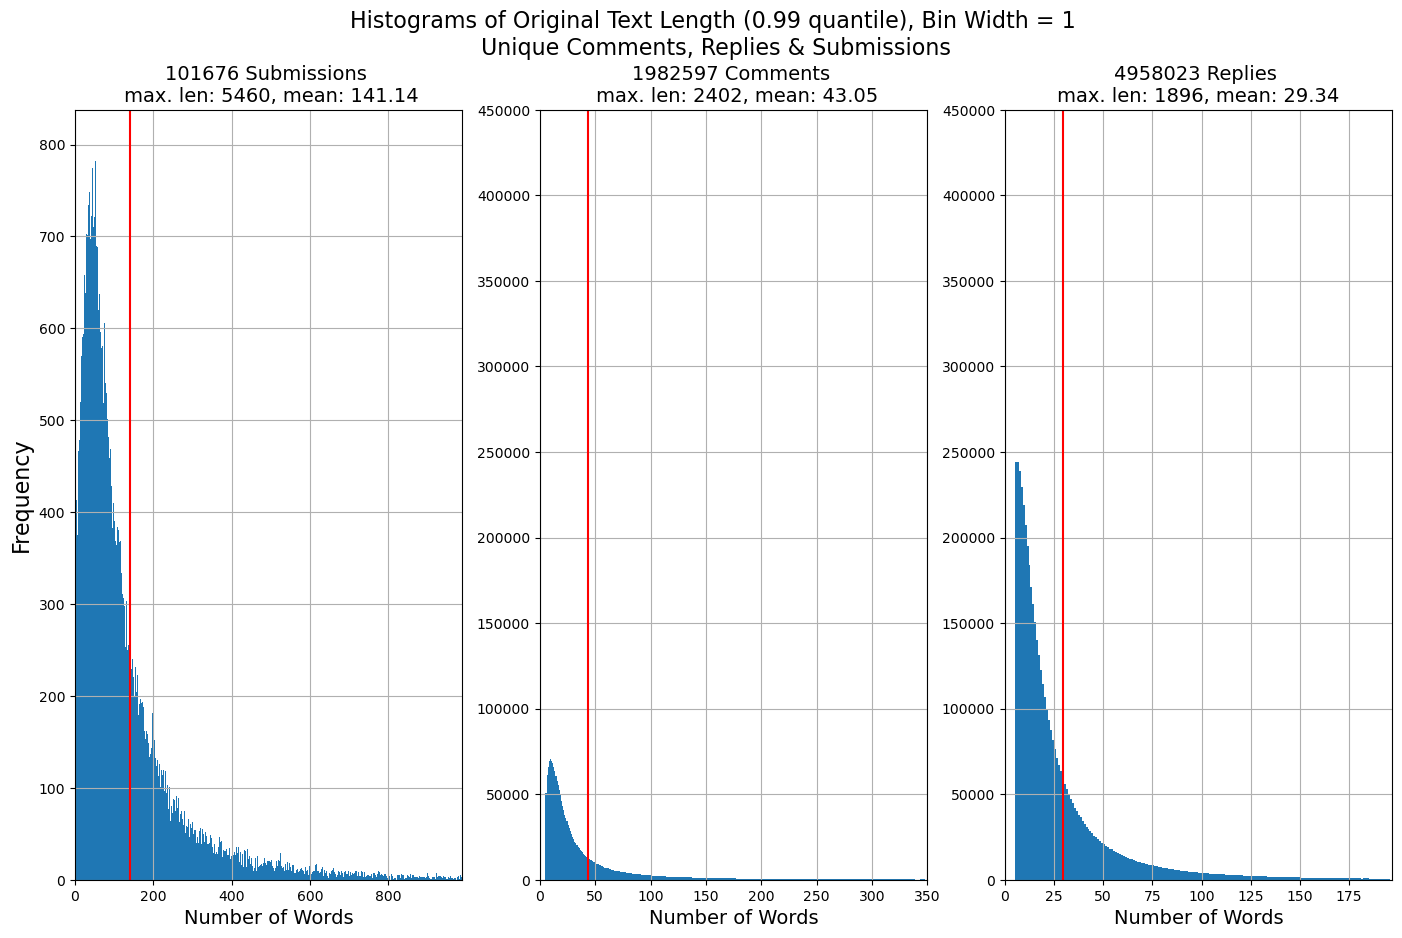

In [63]:


parents_here = parents_OG[parents_OG['len_parent'] <= parents_OG['len_parent'].quantile(0.99)]
child_here = child_OG[child_OG['len_child'] <= child_OG['len_child'].quantile(0.99)]
submission_here = submissions_OG[submissions_OG['len_submission'] <= submissions_OG['len_submission'].quantile(0.99)]



fig, axes = plt.subplots(1, 3, figsize=(17, 10), sharey=False)
fig.suptitle(f"Histograms of Original Text Length (0.99 quantile), Bin Width = 1\n Unique Comments, Replies & Submissions", fontsize=16)

bin_edges = np.arange(0, max(parents_OG['len_parent'].max(), 
                                  child_OG['len_child'].max(), 
                                  submissions_OG['len_submission'].max()) + 1, 1)

axes[0].hist(submission_here['len_submission'], bins=bin_edges)
axes[0].axvline(x = submissions_OG['len_submission'].mean(), color = "red")
axes[0].set_xlim(0, submission_here['len_submission'].max() + 2)
axes[0].set_title(f"{len(submissions_OG)} Submissions \n max. len: {submissions_OG['len_submission'].max()}, mean: {round(submissions_OG['len_submission'].mean(), 2)}", fontsize = 14)
axes[0].set_xlabel("Number of Words", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=16)
axes[0].grid(True)

axes[1].hist(parents_here['len_parent'], bins=bin_edges)
axes[1].axvline(x = parents_OG['len_parent'].mean(), color = "red")
axes[1].set_xlim(0, parents_here['len_parent'].max() + 2)
axes[1].set_ylim(0, 450000)
axes[1].set_title(f"{len(parents_OG)} Comments \n max. len: {parents_OG['len_parent'].max()}, mean: {round(parents_OG['len_parent'].mean(), 2)}", fontsize = 14)
axes[1].set_xlabel("Number of Words", fontsize=14)
axes[1].grid(True)

axes[2].hist(child_here['len_child'], bins=bin_edges)
axes[2].axvline(x = child_OG['len_child'].mean(), color = "red")
axes[2].set_xlim(0, child_here['len_child'].max() + 2)
axes[2].set_ylim(0, 450000)
axes[2].set_title(f"{len(child_OG)} Replies \n max. len: {child_OG['len_child'].max()}, mean: {round(child_OG['len_child'].mean(), 2)} ", fontsize = 14)
axes[2].set_xlabel("Number of Words", fontsize=14)
axes[2].grid(True)



plt.savefig("preprocess_plots/OG_LLM_Text_Len_by_Text_Type_Histogram.pdf")
plt.show()



## **Preprocessing**

1. Download stop words to remove
2. Data Cleaning
    * base text cleaning is done prior to classification, EMI input data file is created later
    * here, just collapse punctuation etc. (which was still helpful for LLM, but not for EMI)

In [64]:
# Download stop words

nltk.data.path.append(nltk_data_path) # set path
nltk.download('stopwords', download_dir=nltk_data_path) # download to path

stop_words = set(stopwords.words('english'))

# check
#stop_words

[nltk_data] Downloading package stopwords to nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
# Preprocessing function

def preprocess(text):
    
    text = text.lower()
    
    # collapse repeated punctuation and letters
    text = re.sub(r'\.{2,}', '.', text)
    text = re.sub(r'\!{2,}', '!', text)
    text = re.sub(r'\?{2,}', '?', text)
    text = re.sub(r'(\w)\1{2,}', r'\1', text)


    # ensure that punctuation is properly separated from words
    text = re.sub(r"([.,!?()\"*:\\/><“”‘’'_~{}\-^@#])", r' \1 ', text)
    text = re.sub(r"(?<!\w)'(\w+\s*)'(?!\w)", r' \1 ', text) # quotation marks around words remove, thers not
    text = re.sub(r'(\])', r' \1 ', text)
    text = re.sub(r'(\[)', r' \1 ', text)

    text = re.sub(r'\d+', ' ', text).strip() # remove any numbers
    text = re.sub(r'\s+', ' ', text).strip()

    # tokenize and remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # manual cleaning from investigation
    to_remove = ["?", "!", ",", ".", "'", "*", "/", "\"", "\\", "[", "]", "(", ")", ":", ">", "<", "“", "”", 
                 "–", "-", "‘", "’", "+", "|", "~", "_", "{", "}", "^", "%", "$", "@", "#"]
    words = [word for word in words if word not in to_remove]
    
    words = " ".join(words)
    
    return words


## **Make Training Texts**

* less data to preprocess, since removed duplicates (based on id)
* can be merged to df later on id

In [66]:
# make training texts

training_texts_all = pd.DataFrame()

for subr in subreddits:

    parent = df_dict[subr][['msg_id_parent', 'body_parent']].drop_duplicates(subset = 'msg_id_parent').rename(columns = {'msg_id_parent' : 'id', 'body_parent' : 'text'})
    child = df_dict[subr][['msg_id_child', 'body_child']].drop_duplicates(subset = 'msg_id_child').rename(columns = {'msg_id_child' : 'id', 'body_child' : 'text'})
    submission = df_dict[subr][['submission_id', 'submission_text']].drop_duplicates(subset = 'submission_id').rename(columns = {'submission_id' : 'id', 'submission_text' : 'text'})
    
    training_texts = pd.DataFrame(pd.concat([parent[['id', 'text']], child[['id', 'text']], submission[['id', 'text']]]).reset_index(drop = True)).reset_index(drop = True)
    print(f"{subr}: ", len(training_texts))

    training_texts_all = pd.concat([training_texts_all, training_texts], ignore_index=True)


#training_texts_all.to_csv("preprocess_outputs/training_texts_all.csv", index = False)
print(len(training_texts_all))

Ask_Politics:  108230
Askpolitics:  14547
PoliticalDiscussion:  1032095
PoliticalDebate:  14722
NeutralPolitics:  70861
politics:  5801841
7042296


In [67]:
training_texts_all

,id,text
0,c7ecp8d,Regarding Perry vs. Brown the current name of ...
1,c7edr13,So what was wrong with or ?
2,c7ee45j,We will be adhering to the AskScience style of...
3,c7eevhv,I was at a conference in November where a grad...
4,c7efwy3,"Stealing the rules might become a trend now, ..."
...,...,...
7042291,18mfx16,The Supreme Court of Colorado has disqualified...
7042292,18mfyba,The Supreme Court of Colorado has disqualified...
7042293,18p9iet,"It's Saturday, folks. Let's all kick back with..."
7042294,18qmiau,"Happy Holidays, ! Welcome to the 'What happene..."


In [68]:
training_texts_all[training_texts_all['text'] == ""]

,id,text


In [21]:
# save for toxcity

training_texts_all.to_csv(
    "../data/toxicity/training_texts_all.csv",
    index=False,
    quoting=1  # csv.QUOTE_ALL
)


In [42]:
training_texts_all = pd.read_csv("../data/toxicity/training_texts_all.csv", engine='python')


**Decision** 

It can happen, that the exact same text is used, once as a comment and once as a reply, for example.

* Therefore, I have 7042296 unique texts, when filtering on text_id's.


* For my analysis of comment and reply interactions, the id's are chosen as the unique identifier.

## **Preprocess Texts (not whole Data Frame)**

In [69]:
training_texts_all['tokens'] = training_texts_all['text'].apply(preprocess)
training_texts_all['len'] = training_texts_all['tokens'].apply(lambda x: len(x.split()))
training_texts_all

,id,text,tokens,len
0,c7ecp8d,Regarding Perry vs. Brown the current name of ...,regarding perry vs brown current name prop cas...,65
1,c7edr13,So what was wrong with or ?,wrong,1
2,c7ee45j,We will be adhering to the AskScience style of...,adhering askscience style moderation could ela...,6
3,c7eevhv,I was at a conference in November where a grad...,conference november grad student yale presente...,56
4,c7efwy3,"Stealing the rules might become a trend now, ...",stealing rules might become trend rules heavil...,12
...,...,...,...,...
7042291,18mfx16,The Supreme Court of Colorado has disqualified...,supreme court colorado disqualified trump futu...,27
7042292,18mfyba,The Supreme Court of Colorado has disqualified...,supreme court colorado disqualified trump futu...,27
7042293,18p9iet,"It's Saturday, folks. Let's all kick back with...",saturday folks let kick back cup coffee share ...,59
7042294,18qmiau,"Happy Holidays, ! Welcome to the 'What happene...",happy holidays welcome happened state last wee...,105


In [16]:
#for subr in subreddits:
#    print(subr)

    # apply preprocesisng to parents, children and submissions
    #df_dict[subr]['parent_tokens'] = df_dict[subr]['body_parent'].apply(preprocess)
    #df_dict[subr]['child_tokens'] = df_dict[subr]['body_child'].apply(preprocess)
    #df_dict[subr]['submission_tokens'] = df_dict[subr]['submission_text'].apply(preprocess)
    
    # determine nr. of words
    #df_dict[subr]['parent_len'] = df_dict[subr]['parent_tokens'].apply(lambda x: len(x.split()))
    #df_dict[subr]['child_len'] = df_dict[subr]['child_tokens'].apply(lambda x: len(x.split()))
    #df_dict[subr]['submission_len'] = df_dict[subr]['submission_tokens'].apply(lambda x: len(x.split()))

AmericanPolitics
Ask_Politics


/tmp/ipykernel_4814/3767436242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[subr]['parent_tokens'] = df_dict[subr]['body_parent'].apply(preprocess)
/tmp/ipykernel_4814/3767436242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[subr]['child_tokens'] = df_dict[subr]['body_child'].apply(preprocess)
/tmp/ipykernel_4814/3767436242.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

PoliticalDiscussion


/tmp/ipykernel_4814/3767436242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[subr]['parent_tokens'] = df_dict[subr]['body_parent'].apply(preprocess)
/tmp/ipykernel_4814/3767436242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[subr]['child_tokens'] = df_dict[subr]['body_child'].apply(preprocess)
/tmp/ipykernel_4814/3767436242.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

PoliticalDebate


/tmp/ipykernel_4814/3767436242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[subr]['parent_tokens'] = df_dict[subr]['body_parent'].apply(preprocess)
/tmp/ipykernel_4814/3767436242.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[subr]['child_tokens'] = df_dict[subr]['body_child'].apply(preprocess)
/tmp/ipykernel_4814/3767436242.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

politics


## **Merge based on id**

In [70]:

for subr in subreddits:
    
    # parents
    df_dict[subr] = df_dict[subr].merge(training_texts_all, left_on =['msg_id_parent'], right_on = 'id').drop(
        columns = ['id', 'text']).rename(columns = {'tokens' : 'parent_tokens', 'len' : 'parent_len'})
    # childer
    df_dict[subr] = df_dict[subr].merge(training_texts_all, left_on =['msg_id_child'], right_on = 'id').drop(
        columns = ['id', 'text']).rename(columns = {'tokens' : 'child_tokens', 'len' : 'child_len'})
    # submissions
    df_dict[subr] = df_dict[subr].merge(training_texts_all, left_on =['submission_id'], right_on = 'id').drop(
        columns = ['id', 'text']).rename(columns = {'tokens' : 'submission_tokens', 'len' : 'submission_len'})



In [71]:
df_dict["Ask_Politics"]

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,exact_time_submission,len_parent,len_child,len_submission,parent_tokens,parent_len,child_tokens,child_len,submission_tokens,submission_len
0,c7ecp8d,c7ecs2n,Ted Olson and David Boies are extremely good ...,Ask_Politics,1.355167e+09,karmanaut,4.0,4,0.0,14m325,...,1.355161e+09,123,79,20,regarding perry vs brown current name prop cas...,65,ted olson david boies extremely good keeping t...,38,regarding doma nd regarding california prop ba...,10
1,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5,0.0,14m325,...,1.355161e+09,123,52,20,regarding perry vs brown current name prop cas...,65,quick note think calling hollingsworth v perry...,27,regarding doma nd regarding california prop ba...,10
2,c7ecp8d,c7eflag,SCOTUS has already overridden state law in cas...,Ask_Politics,1.355175e+09,zossima,3.0,3,0.0,14m325,...,1.355161e+09,123,102,20,regarding perry vs brown current name prop cas...,65,scotus already overridden state law cases invo...,53,regarding doma nd regarding california prop ba...,10
3,c7efx8q,c7ejh1d,I don't think they will either uphold Prop 8 o...,Ask_Politics,1.355188e+09,fathermocker,2.0,2,0.0,14m325,...,1.355161e+09,228,55,20,suspect going split baby striking doma upholdi...,123,think either uphold prop dodge think strike pr...,28,regarding doma nd regarding california prop ba...,10
4,c7efx8q,c7f8140,"It's possible they could strike down Prop 8, b...",Ask_Politics,1.355286e+09,PKMKII,1.0,1,0.0,14m325,...,1.355161e+09,228,48,20,suspect going split baby striking doma upholdi...,123,possible could strike prop word ruling specifi...,24,regarding doma nd regarding california prop ba...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54257,jw3iofg,k8f1j20,Plenty of other former and current elected off...,Ask_Politics,1.699481e+09,thisfunnieguy,1.0,1,0.0,15frtsy,...,1.690931e+09,29,43,39,doesnt even matter real goal banana republic d...,18,plenty former current elected officials charge...,25,got newest trump indictment damn wild noticed ...,28
54258,fcyrekh,k8kje6m,Apparentlly tho a presedent can and does start...,Ask_Politics,1.699571e+09,Busy-Factor-2542,1.0,1,0.0,ejj4xd,...,1.578075e+09,58,10,103,president declare war congress get choose batt...,30,apparentlly tho presedent start wars tho,6,friend mine told wars declared democratic pres...,51
54259,k9fz0e9,k9wo2gy,Eventually everyone is going to realize that t...,Ask_Politics,1.700413e+09,SecondGuesserIsBack2,-4.0,-4,0.0,17w3s8o,...,1.700082e+09,35,49,78,like witness humans know magats know intimidat...,19,eventually everyone going realize trying prose...,27,yesterday lawyer one defendants georgia rico c...,39
54260,k9fz0e9,kb8de02,"Man 40 years of biden bribes, collusion, and d...",Ask_Politics,1.701241e+09,Sarasota33907,1.0,1,0.0,17w3s8o,...,1.700082e+09,35,68,78,like witness humans know magats know intimidat...,19,man years biden bribes collusion drugs peep gu...,34,yesterday lawyer one defendants georgia rico c...,39


## **Check for empty texts**

* after merge, because if submission got empty, drop all belonging comment & reply interactions as well
    * then reduce training texts based on retained texts 

In [25]:
len(training_texts_all[training_texts_all['len'] == 0]) / 7042296 

0.0004345173789911699

In [72]:
# find interactions, where one text got empty, remove reffering interaction as a whole

rows_to_remove = {}

for subr in subreddits:
    
    rows_to_remove[subr] = df_dict[subr][
        (df_dict[subr][["child_len", "parent_len", "submission_len"]] == 0).any(axis=1)
    ]



rows_to_remove['Ask_Politics']
#rows_to_remove['Askpolitics']
#rows_to_remove['PoliticalDiscussion']
#rows_to_remove['PoliticalDebate']
#rows_to_remove['politics']

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,exact_time_submission,len_parent,len_child,len_submission,parent_tokens,parent_len,child_tokens,child_len,submission_tokens,submission_len
2801,ca4wqql,ca4y48a,"Also, free trade prevents war",Ask_Politics,1.369370e+09,gsfgf,2.0,2,0.0,1ey58f,...,1.369364e+09,92,5,4,good basic level allows us specialize profit o...,49,also free trade prevents war,5,,0
3559,cbbiqzb,cbbs76q,Nevis has a huge violence problem. MauritiusNa...,Ask_Politics,1.374984e+09,pennwastemanagement,2.0,2,0.0,1j63po,...,1.374947e+09,80,31,4,several caribbean nations fit category barbado...,46,nevis huge violence problem mauritiusnamibiase...,19,,0
4756,cd3ivff,cd3j0ep,or they could nominate an actual moderate and ...,Ask_Politics,1.383196e+09,bacteriadude,4.0,4,0.0,1pkzje,...,1.383182e+09,11,18,4,bad whatever idiot gop nominates,5,could nominate actual moderate win landslide h...,8,,0
4757,cd3ivff,cd3jpo8,It's not just a two horse race.,Ask_Politics,1.383199e+09,Outforbrunch,1.0,1,0.0,1pkzje,...,1.383182e+09,11,7,4,bad whatever idiot gop nominates,5,two horse race,3,,0
4758,cd3gysd,cd3jniy,but if there is one thing Obama has taught me...,Ask_Politics,1.383199e+09,Outforbrunch,0.0,0,0.0,1pkzje,...,1.383182e+09,125,31,4,think ideas ideology similar obama one thing o...,52,one thing obama taught anybody able get level ...,13,,0
4759,cd3gysd,cd3of5x,Yes -- what we need is more divisiveness and m...,Ask_Politics,1.383227e+09,7Redacted,3.0,3,0.0,1pkzje,...,1.383182e+09,125,12,4,think ideas ideology similar obama one thing o...,52,yes need divisiveness misplaced partisan anger,6,,0
4760,cd3jhf2,cd3jp5u,Exactly. Theoretically voting for her is theor...,Ask_Politics,1.383199e+09,Outforbrunch,3.0,3,0.0,1pkzje,...,1.383182e+09,18,21,4,liked past years yes since lot different happe...,8,exactly theoretically voting theoretically vot...,10,,0
4761,cd3er0j,cd3kba7,What do you mean by this?,Ask_Politics,1.383202e+09,WhiteManinthePalais,8.0,8,0.0,1pkzje,...,1.383182e+09,14,6,4,beholden beholden gets political dynasties us,6,mean,1,,0
4762,cd3k7av,cd3l17k,Insider knowledge does not equal qualification...,Ask_Politics,1.383206e+09,Outforbrunch,1.0,1,0.0,1pkzje,...,1.383182e+09,82,14,4,qualified candidate think think spouse preside...,33,insider knowledge equal qualifications good le...,9,,0
6411,cgkrss4,cgl2tup,Obama signs ban on public funding of president...,Ask_Politics,1.396744e+09,christ0ph,2.0,2,0.0,229v3h,...,1.396710e+09,158,241,1,first get notion public financing candidates b...,86,obama signs ban public funding presidential ca...,154,,0


In [73]:
# drop 
for subr in subreddits:

    print(f"{subr} has ", len(rows_to_remove[subr]), "interactions which got empty texts and will be removed")
    print("Share: ", len(rows_to_remove[subr]) / len(df_dict[subr]))
    
    df_dict[subr] = df_dict[subr].drop(rows_to_remove[subr].index).reset_index(drop = True)

    print("After dropping ", len(df_dict[subr]), "interactions remain")
    print("----------------------------")
    

Ask_Politics has  59 interactions which got empty texts and will be removed
Share:  0.0010873170911503446
After dropping  54203 interactions remain
----------------------------
Askpolitics has  9 interactions which got empty texts and will be removed
Share:  0.0014144271570014145
After dropping  6354 interactions remain
----------------------------
PoliticalDiscussion has  798 interactions which got empty texts and will be removed
Share:  0.001194372976637885
After dropping  667335 interactions remain
----------------------------
PoliticalDebate has  3 interactions which got empty texts and will be removed
Share:  0.000343210159020707
After dropping  8738 interactions remain
----------------------------
NeutralPolitics has  9 interactions which got empty texts and will be removed
Share:  0.0001989829759009507
After dropping  45221 interactions remain
----------------------------
politics has  3594 interactions which got empty texts and will be removed
Share:  0.0008607777081086985
Afte

In [74]:
# find remaining ids

ids_to_keep = []

for subr in subreddits:
    
    ids_to_keep.extend(list(set(df_dict[subr]['msg_id_parent'])))
    ids_to_keep.extend(list(set(df_dict[subr]['msg_id_child'])))
    ids_to_keep.extend(list(set(df_dict[subr]['submission_id'])))

ids_to_keep = list(set(ids_to_keep))


In [75]:
# filter training texts to keep

training_texts_all = training_texts_all[training_texts_all['id'].isin(ids_to_keep)].reset_index(drop = True)
training_texts_all

,id,text,tokens,len
0,c7ecp8d,Regarding Perry vs. Brown the current name of ...,regarding perry vs brown current name prop cas...,65
1,c7edr13,So what was wrong with or ?,wrong,1
2,c7ee45j,We will be adhering to the AskScience style of...,adhering askscience style moderation could ela...,6
3,c7eevhv,I was at a conference in November where a grad...,conference november grad student yale presente...,56
4,c7efwy3,"Stealing the rules might become a trend now, ...",stealing rules might become trend rules heavil...,12
...,...,...,...,...
7035716,18mfx16,The Supreme Court of Colorado has disqualified...,supreme court colorado disqualified trump futu...,27
7035717,18mfyba,The Supreme Court of Colorado has disqualified...,supreme court colorado disqualified trump futu...,27
7035718,18p9iet,"It's Saturday, folks. Let's all kick back with...",saturday folks let kick back cup coffee share ...,59
7035719,18qmiau,"Happy Holidays, ! Welcome to the 'What happene...",happy holidays welcome happened state last wee...,105


# **Save to outputs**

In [49]:
training_texts_all[training_texts_all['text'] != ""]

,id,text,tokens,len
0,c7ecp8d,Regarding Perry vs. Brown the current name of ...,regarding perry vs brown current name prop cas...,65
1,c7edr13,So what was wrong with or ?,wrong,1
2,c7ee45j,We will be adhering to the AskScience style of...,adhering askscience style moderation could ela...,6
3,c7eevhv,I was at a conference in November where a grad...,conference november grad student yale presente...,56
4,c7efwy3,"Stealing the rules might become a trend now, ...",stealing rules might become trend rules heavil...,12
...,...,...,...,...
7035716,18mfx16,The Supreme Court of Colorado has disqualified...,supreme court colorado disqualified trump futu...,27
7035717,18mfyba,The Supreme Court of Colorado has disqualified...,supreme court colorado disqualified trump futu...,27
7035718,18p9iet,"It's Saturday, folks. Let's all kick back with...",saturday folks let kick back cup coffee share ...,59
7035719,18qmiau,"Happy Holidays, ! Welcome to the 'What happene...",happy holidays welcome happened state last wee...,105


In [31]:
# drop text (OG text) and rename tokens to text --> later, this file is imported, i.e. for embedding. There, "text" is expected to be the cleaned tokens

training_texts_all = training_texts_all.drop(columns = ['text']).rename(columns = {'tokens' : 'text'})
training_texts_all

,id,text,len
0,c7ecp8d,regarding perry vs brown current name prop cas...,65
1,c7edr13,wrong,1
2,c7ee45j,adhering askscience style moderation could ela...,6
3,c7eevhv,conference november grad student yale presente...,56
4,c7efwy3,stealing rules might become trend rules heavil...,12
...,...,...,...
7035716,18mfx16,supreme court colorado disqualified trump futu...,27
7035717,18mfyba,supreme court colorado disqualified trump futu...,27
7035718,18p9iet,saturday folks let kick back cup coffee share ...,59
7035719,18qmiau,happy holidays welcome happened state last wee...,105


In [51]:
# to csv --> for EMI


training_texts_all.to_csv(csv_output_path, index = False)

# to json file
training_texts_all.to_json(json_output_path, orient='records', lines=True)

with open(txt_output_path, 'w', encoding='utf-8') as f:
    for sentence in training_texts_all['text']:
        f.write(sentence + "\n")

In [76]:
# whole reddit df

# FAILS TO SAVE

reddit_df = pd.concat([df_dict['Ask_Politics'], df_dict['Askpolitics'], df_dict['PoliticalDebate'], df_dict['PoliticalDiscussion'],
                       df_dict['NeutralPolitics'], df_dict['politics']]).reset_index(drop = True)
reddit_df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,exact_time_submission,len_parent,len_child,len_submission,parent_tokens,parent_len,child_tokens,child_len,submission_tokens,submission_len
0,c7ecp8d,c7ecs2n,Ted Olson and David Boies are extremely good ...,Ask_Politics,1.355167e+09,karmanaut,4.0,4.0,0.0,14m325,...,1.355161e+09,123,79,20,regarding perry vs brown current name prop cas...,65,ted olson david boies extremely good keeping t...,38,regarding doma nd regarding california prop ba...,10
1,c7ecp8d,c7ecxpk,Just a quick note- I think they're calling it ...,Ask_Politics,1.355167e+09,zoolander951,5.0,5.0,0.0,14m325,...,1.355161e+09,123,52,20,regarding perry vs brown current name prop cas...,65,quick note think calling hollingsworth v perry...,27,regarding doma nd regarding california prop ba...,10
2,c7ecp8d,c7eflag,SCOTUS has already overridden state law in cas...,Ask_Politics,1.355175e+09,zossima,3.0,3.0,0.0,14m325,...,1.355161e+09,123,102,20,regarding perry vs brown current name prop cas...,65,scotus already overridden state law cases invo...,53,regarding doma nd regarding california prop ba...,10
3,c7efx8q,c7ejh1d,I don't think they will either uphold Prop 8 o...,Ask_Politics,1.355188e+09,fathermocker,2.0,2.0,0.0,14m325,...,1.355161e+09,228,55,20,suspect going split baby striking doma upholdi...,123,think either uphold prop dodge think strike pr...,28,regarding doma nd regarding california prop ba...,10
4,c7efx8q,c7f8140,"It's possible they could strike down Prop 8, b...",Ask_Politics,1.355286e+09,PKMKII,1.0,1.0,0.0,14m325,...,1.355161e+09,228,48,20,suspect going split baby striking doma upholdi...,123,possible could strike prop word ruling specifi...,24,regarding doma nd regarding california prop ba...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953546,kfkh5ib,kfmd52k,Fact-checking doesnt work if no one hears you ...,politics,1.703978e+09,Knightforlife,NaN,NaN,NaN,18uirzt,...,1.703952e+09,8,13,100,jen sorensen future veterans information wars,6,fact checking doesnt work one hears alarming true,8,saturday folks let kick back cup coffee share ...,59
4953547,kfklsb6,kforzbx,This is such a spot on interpretation of what'...,politics,1.704023e+09,bakerfredricka,NaN,NaN,NaN,18uirzt,...,1.703952e+09,8,12,100,yakima herald republic papers syndicate koterba,6,spot interpretation really going,4,saturday folks let kick back cup coffee share ...,59
4953548,kfmq5kr,kfp6tzv,Voting is not nearly that simple. In a first p...,politics,1.704032e+09,glassjar1,NaN,NaN,NaN,18uirzt,...,1.703952e+09,6,290,100,courtesy star tribune steve sack,5,voting nearly simple first past post system al...,157,saturday folks let kick back cup coffee share ...,59
4953549,kfp3d4v,kfp8xh8,"also, try explaining why biden is better to a ...",politics,1.704033e+09,HaulinBoats,NaN,NaN,NaN,18uirzt,...,1.703952e+09,8,23,100,doonesbury trudeau explain like five,5,also try explaining biden better trump support...,14,saturday folks let kick back cup coffee share ...,59


* reddit_df_OG : all 4.958.023 interactions
* reddit_df : 4.953.551 interactions, where no text got empty, during preprocessing

## Save subreddits

* Does not work as a whole
* Important columns: ids', tokens and token length 

In [75]:
def rename_and_save(df, subr):

    df = df.rename(columns = {'len_parent' : 'OG_parent_len', 'len_child': 'OG_child_len', 'len_submission' : 'OG_sumbission_len'})
    df = df[['msg_id_parent', 'msg_id_child', 'submission_id', 
             'OG_parent_len', 'OG_child_len', 'OG_sumbission_len', 
             'parent_tokens', 'parent_len', 
             'child_tokens', 'child_len', 
             'submission_tokens', 'submission_len']]
    df.to_csv(f"preprocess_outputs/{subr}_full.csv", index = False)



In [77]:
for subr in subreddits:

    rename_and_save(df_dict[subr], subr)

***
# **Reimport**

In [19]:
training_texts_all = pd.read_csv(csv_output_path)
training_texts_all

,id,text,len
0,c7ecp8d,regarding perry vs brown current name prop cas...,65
1,c7edr13,wrong,1
2,c7ee45j,adhering askscience style moderation could ela...,6
3,c7eevhv,conference november grad student yale presente...,56
4,c7efwy3,stealing rules might become trend rules heavil...,12
...,...,...,...
7035716,18mfx16,supreme court colorado disqualified trump futu...,27
7035717,18mfyba,supreme court colorado disqualified trump futu...,27
7035718,18p9iet,saturday folks let kick back cup coffee share ...,59
7035719,18qmiau,happy holidays welcome happened state last wee...,105


In [20]:

df_dict_test = {}

df_dict_test['Askpolitics'] = pd.read_csv("preprocess_outputs/Askpolitics_full.csv")
df_dict_test['Ask_Politics'] = pd.read_csv("preprocess_outputs/Ask_Politics_full.csv")
df_dict_test['PoliticalDebate'] = pd.read_csv("preprocess_outputs/PoliticalDebate_full.csv")
df_dict_test['PoliticalDiscussion'] = pd.read_csv("preprocess_outputs/PoliticalDiscussion_full.csv")
df_dict_test['NeutralPolitics'] = pd.read_csv("preprocess_outputs/NeutralPolitics_full.csv")
df_dict_test['politics'] = pd.read_csv("preprocess_outputs/politics_full.csv")


***
***


## **Check lengths of training texts (over all)**

* Some texts are now < 5 words
    * However, that threshold was to give the LLM context, to classify disagreement
    * For EMI score, texts could be shorter (doing double check in Meeting with Peer and Segun)  

In [21]:
#training_texts_all['len'] = training_texts_all['text'].apply(lambda t: len(t.split()))

pd.DataFrame(training_texts_all['len'].value_counts().reset_index()).sort_values('len')

,len,count
29,1,40627
11,2,199392
4,3,432425
0,4,560207
1,5,554644
...,...,...
1083,2363,1
916,2678,1
926,2909,1
957,2929,1


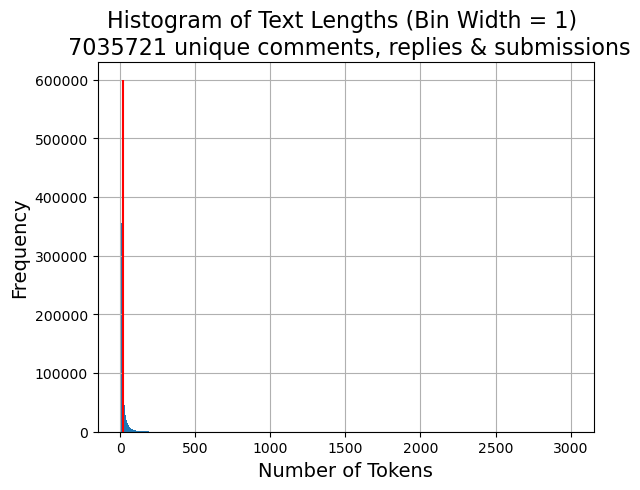

In [22]:
training_texts_all = training_texts_all[training_texts_all['len'] > 0]

bin_edges = np.arange(0, training_texts_all['len'].max() + 1, 1)
training_texts_all['len'].hist(bins=bin_edges)

plt.title(f"Histogram of Text Lengths (Bin Width = 1) \n {len(training_texts_all)} unique comments, replies & submissions",fontsize = 16)
plt.xlabel("Number of Tokens", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.vlines(training_texts_all['len'].mean(), ymin = 0, ymax = 600000, color = 'red')
plt.grid(True)

plt.show()

In [37]:
training_texts_all['len'].quantile(0.99)

136.0

In [38]:
print("Mean:", training_texts_all['len'].mean())
print("Median:", training_texts_all['len'].quantile(0.5))
print("Max:", training_texts_all['len'].max())
print("Min:", training_texts_all['len'].min())


Mean: 17.705408159305918
Median: 10.0
Max: 3002
Min: 1


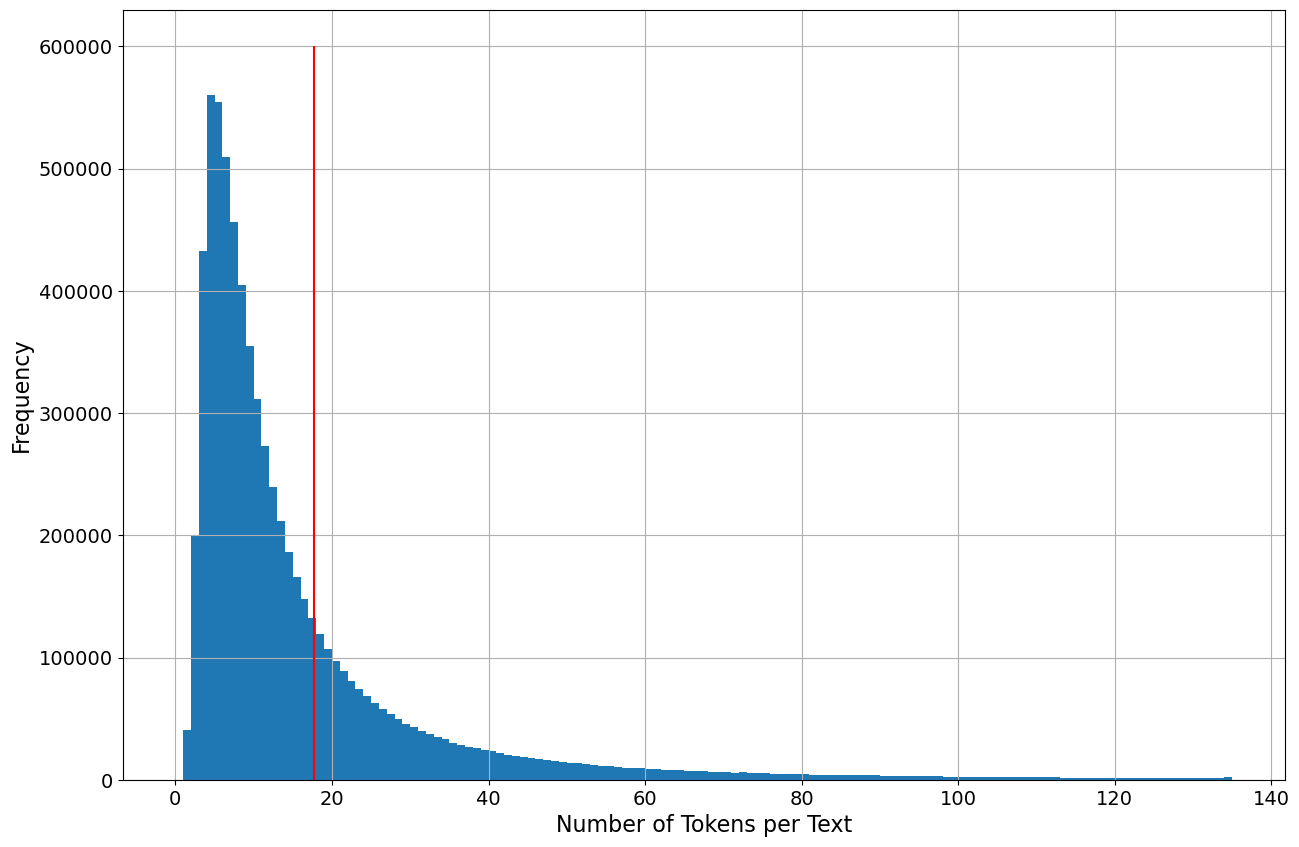

In [24]:
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18  # If you decide to use a title

training_texts_all_filtered = training_texts_all[
    training_texts_all['len'] < training_texts_all['len'].quantile(0.99)
]

plt.figure(figsize=(15, 10))

bin_edges = np.arange(0, training_texts_all_filtered['len'].max() + 1, 1)
training_texts_all_filtered['len'].hist(bins=bin_edges)

# Set axis labels
plt.xlabel("Number of Tokens per Text", fontsize=label_fontsize)
plt.ylabel("Frequency", fontsize=label_fontsize)

# Set tick label sizes
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

# Add mean line
plt.vlines(training_texts_all['len'].mean(), ymin=0, ymax=600000, color='red')

plt.grid(True)

# Save and show
plt.savefig("preprocess_plots/Training_Token_len_Histogram.pdf", bbox_inches='tight')
plt.show()

In [43]:
f"Data was limited to the 99%-quantile, resulting in {len(training_texts_all_filtered)} unique texts"

'Data was limited to the 99%-quantile, resulting in 6965249 unique texts'

In [41]:
# check punctuation

for tokens in training_texts_all['text'].sample(5):  # Check random 5 rows
    print(tokens)

people disputing dear leaders claims want none
main job defend racist republican policies
rosenstein pulled mueller oversight apparently
jones wait weeks take office gop could still use luther strange vote pass legislation like tax bill jones likely take office within days point senate republicans democrats counting two independent senators caucus democrats democratic column
want use private email could deletehide things mean thing ultimately caught even matter given


## **Descriptive Stats on Text length by text type**

$\to$ watch out, now modifying the debagree data again. Comments and Submissions will be duplicated 

In [77]:
parents = reddit_df[['msg_id_parent', 'parent_len']].drop_duplicates(subset = "msg_id_parent")
child = reddit_df[['msg_id_child', 'child_len']].drop_duplicates(subset = "msg_id_child")
submissions = reddit_df[['submission_id', 'submission_len']].drop_duplicates(subset = "submission_id")


len(parents) + len(submissions) +len(child)

7035721

In [79]:
parents['parent_len'].mean()

22.17811666038961

In [80]:
child['child_len'].mean()

14.780837019746036

In [81]:
submissions['submission_len'].mean()

73.19843805466809

### **EMI input texts, full**

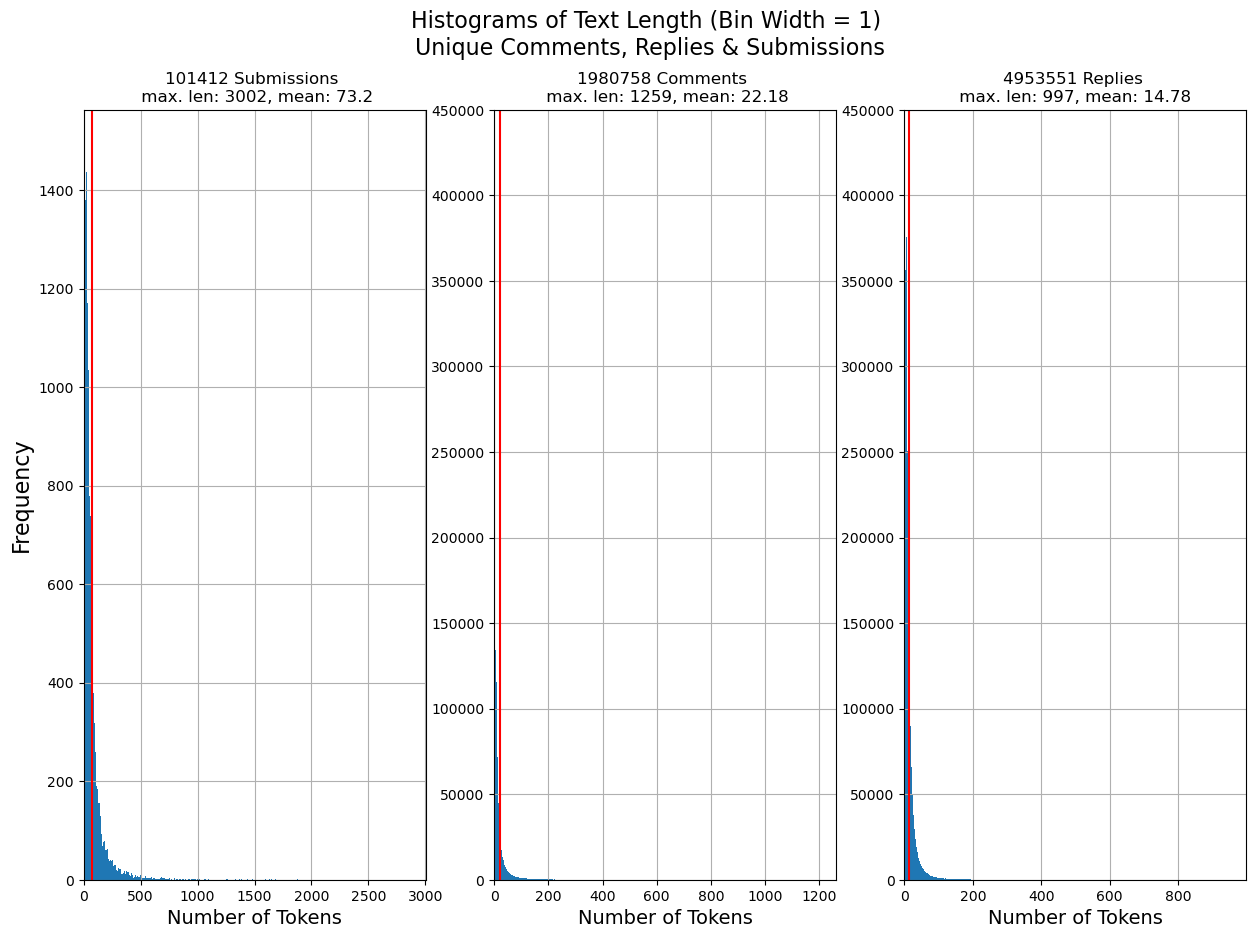

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
fig.suptitle(f"Histograms of Text Length (Bin Width = 1)\n Unique Comments, Replies & Submissions", fontsize=16)

bin_edges = np.arange(0, max(parents['parent_len'].max(), 
                                  child['child_len'].max(), 
                                  submissions['submission_len'].max()) + 1, 1)

axes[0].hist(submissions['submission_len'], bins=bin_edges)
axes[0].axvline(x = submissions['submission_len'].mean(), color = "red")
axes[0].set_xlim(0, submissions['submission_len'].max() + 2)
axes[0].set_title(f"{len(submissions)} Submissions \n max. len: {submissions['submission_len'].max()}, mean: {round(submissions['submission_len'].mean(), 2)}")
axes[0].set_xlabel("Number of Tokens", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=16)
axes[0].grid(True)

axes[1].hist(parents['parent_len'], bins=bin_edges)
axes[1].axvline(x = parents['parent_len'].mean(), color = "red")
axes[1].set_xlim(0, parents['parent_len'].max() + 2)
axes[1].set_ylim(0, 450000)
axes[1].set_title(f"{len(parents)} Comments \n max. len: {parents['parent_len'].max()}, mean: {round(parents['parent_len'].mean(), 2)}")
axes[1].set_xlabel("Number of Tokens", fontsize=14)
axes[1].grid(True)

axes[2].hist(child['child_len'], bins=bin_edges)
axes[2].axvline(x = child['child_len'].mean(), color = "red")
axes[2].set_xlim(0, child['child_len'].max() + 2)
axes[2].set_ylim(0, 450000)
axes[2].set_title(f"{len(child)} Replies \n max. len: {child['child_len'].max()}, mean: {round(child['child_len'].mean(), 2)} ")
axes[2].set_xlabel("Number of Tokens", fontsize=14)
axes[2].grid(True)


### **Now, EMI input texts, but only 99% quantile, for better visual**

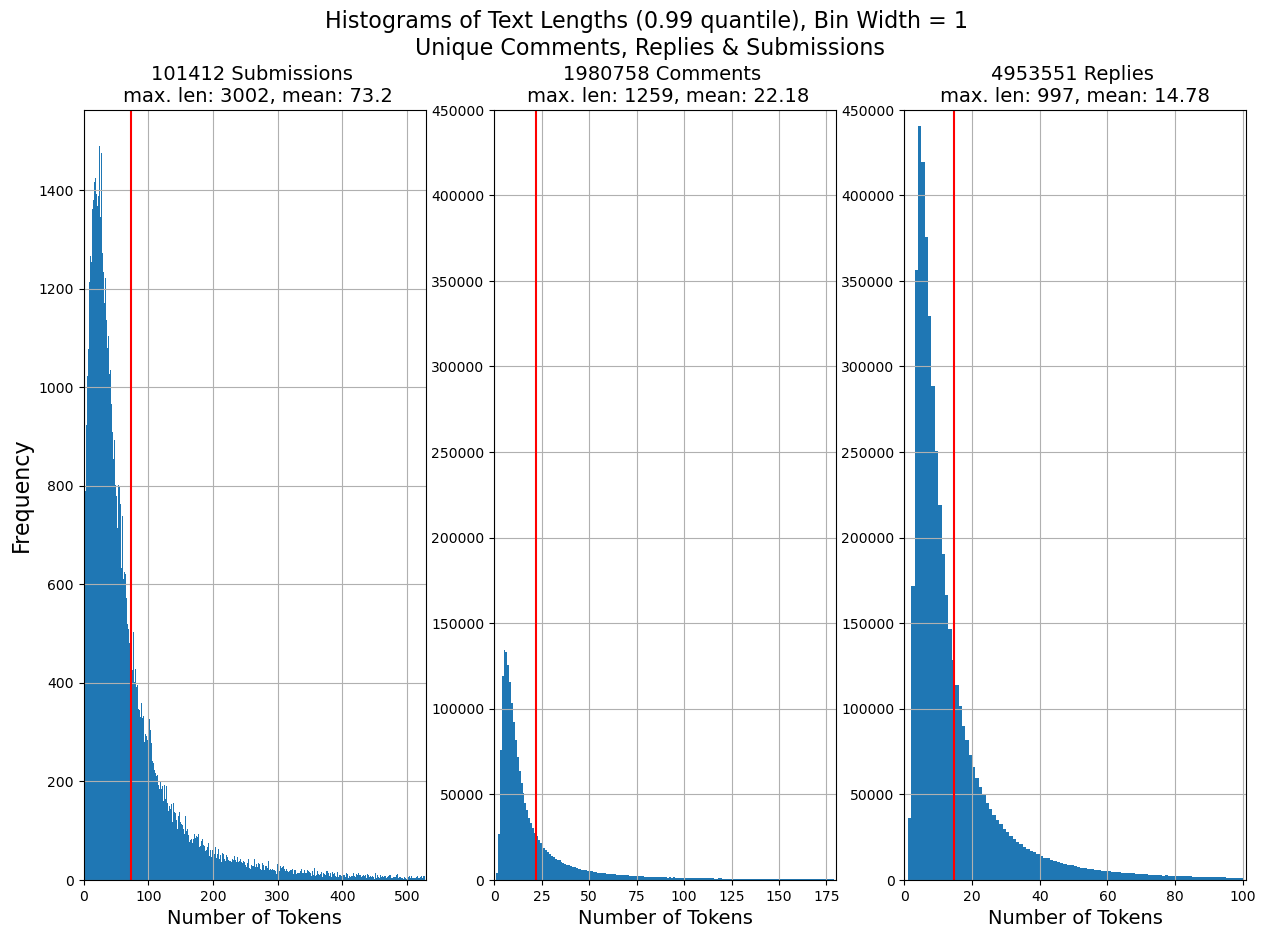

In [52]:
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18
facet_title_fontsize = 16


# filter
parents_quant = parents[parents['parent_len'] <= parents['parent_len'].quantile(0.99)]
child_quant = child[child['child_len'] <= child['child_len'].quantile(0.99)]
submission_quant = submissions[submissions['submission_len'] <= submissions['submission_len'].quantile(0.99)]


# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
fig.suptitle(f"Histograms of Text Lengths (0.99 quantile), Bin Width = 1\n Unique Comments, Replies & Submissions", fontsize=16)

bin_edges = np.arange(0, max(parents['parent_len'].max(), 
                                  child['child_len'].max(), 
                                  submissions['submission_len'].max()) + 1, 1)

axes[0].hist(submission_quant['submission_len'], bins=bin_edges)
axes[0].axvline(x = submissions['submission_len'].mean(), color = "red")
axes[0].set_xlim(0, submission_quant['submission_len'].max() + 2)
axes[0].set_title(f"Submissions (#{len(submissions)})", fontsize = 14)
axes[0].set_xlabel("Number of Tokens", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=16)
# Set tick label sizes
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)

axes[0].grid(True)

axes[1].hist(parents_quant['parent_len'], bins=bin_edges)
axes[1].axvline(x = parents['parent_len'].mean(), color = "red")
axes[1].set_xlim(0, parents_quant['parent_len'].max() + 2)
axes[1].set_ylim(0, 450000)
axes[1].set_title(f"Comments (#{len(parents)})", fontsize = 14)
axes[1].set_xlabel("Number of Tokens", fontsize=14)
axes[1].grid(True)

axes[2].hist(child_quant['child_len'], bins=bin_edges)
axes[2].axvline(x = child['child_len'].mean(), color = "red")
axes[2].set_xlim(0, child_quant['child_len'].max() + 2)
axes[2].set_ylim(0, 450000)
axes[2].set_title(f"Replies (#{len(child)})", fontsize = 14)
axes[2].set_xlabel("Number of Tokens", fontsize=14)
axes[2].grid(True)




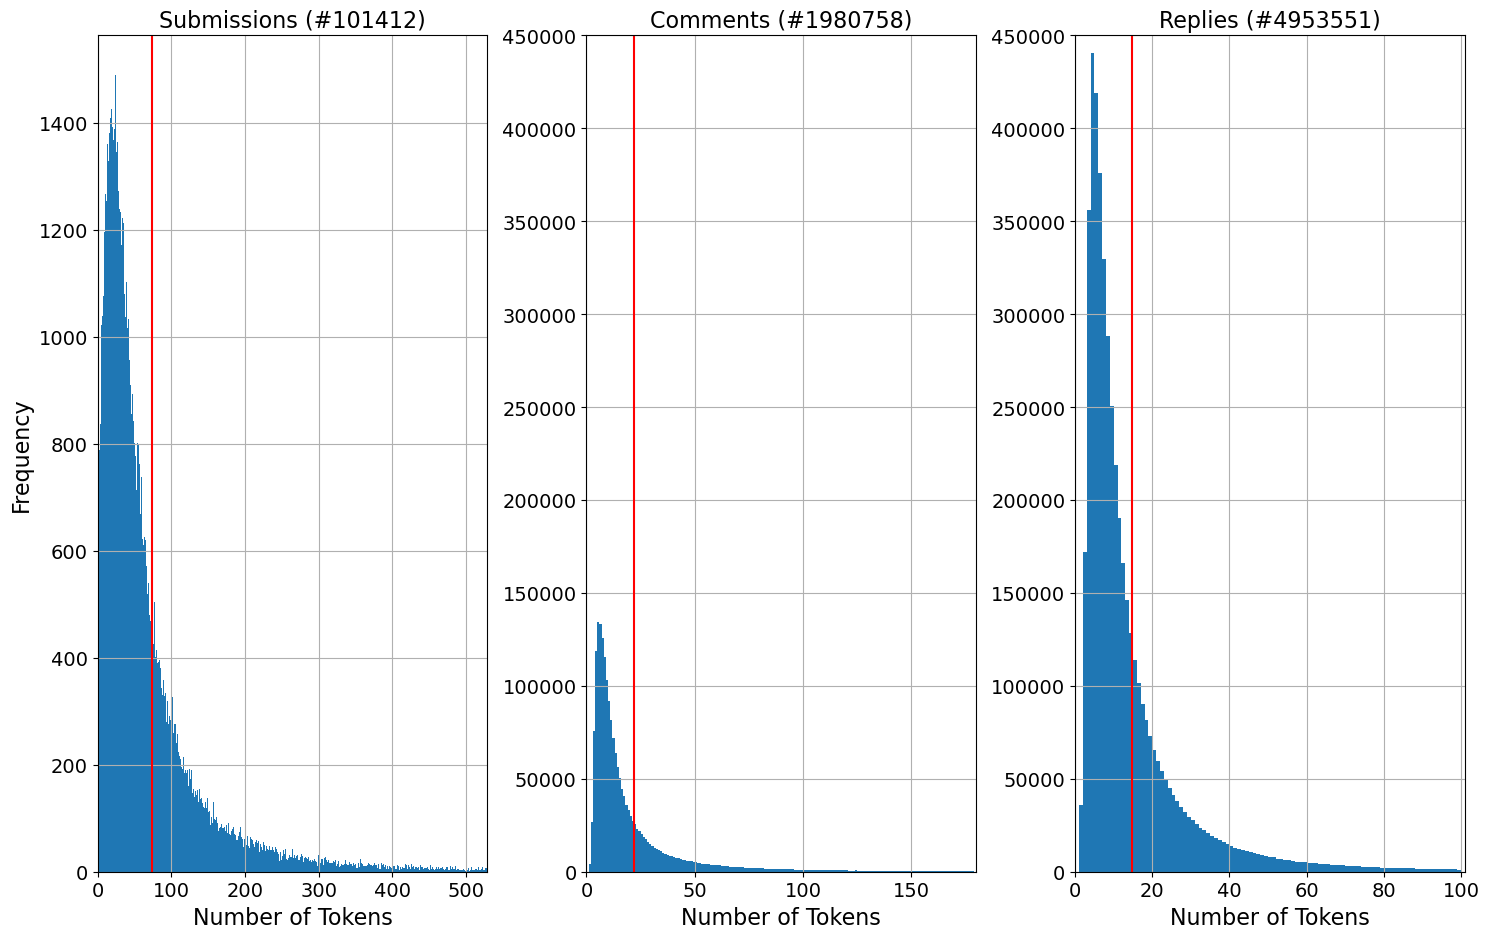

In [85]:
label_fontsize = 16
tick_fontsize = 14
title_fontsize = 18
facet_title_fontsize = 16

# Filter
parents_quant = parents[parents['parent_len'] <= parents['parent_len'].quantile(0.99)]
child_quant = child[child['child_len'] <= child['child_len'].quantile(0.99)]
submission_quant = submissions[submissions['submission_len'] <= submissions['submission_len'].quantile(0.99)]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=False)
#fig.suptitle(
#    "Histograms of Text Lengths (0.99 quantile), Bin Width = 1\nUnique Comments, Replies & Submissions",
#    fontsize=title_fontsize
#)

bin_edges = np.arange(
    0,
    max(parents['parent_len'].max(), child['child_len'].max(), submissions['submission_len'].max()) + 1,
    1
)

# Submissions
axes[0].hist(submission_quant['submission_len'], bins=bin_edges)
axes[0].axvline(x=submissions['submission_len'].mean(), color="red")
axes[0].set_xlim(0, submission_quant['submission_len'].max() + 2)
axes[0].set_title(f"Submissions (#{len(submissions)})", fontsize=facet_title_fontsize)
axes[0].set_xlabel("Number of Tokens", fontsize=label_fontsize)
axes[0].set_ylabel("Frequency", fontsize=label_fontsize)
axes[0].tick_params(axis='both', labelsize=tick_fontsize)
axes[0].grid(True)

# Comments
axes[1].hist(parents_quant['parent_len'], bins=bin_edges)
axes[1].axvline(x=parents['parent_len'].mean(), color="red")
axes[1].set_xlim(0, parents_quant['parent_len'].max() + 2)
axes[1].set_ylim(0, 450000)
axes[1].set_title(f"Comments (#{len(parents)})", fontsize=facet_title_fontsize)
axes[1].set_xlabel("Number of Tokens", fontsize=label_fontsize)
axes[1].tick_params(axis='both', labelsize=tick_fontsize)
axes[1].grid(True)

# Replies
axes[2].hist(child_quant['child_len'], bins=bin_edges)
axes[2].axvline(x=child['child_len'].mean(), color="red")
axes[2].set_xlim(0, child_quant['child_len'].max() + 2)
axes[2].set_ylim(0, 450000)
axes[2].set_title(f"Replies (#{len(child)})", fontsize=facet_title_fontsize)
axes[2].set_xlabel("Number of Tokens", fontsize=label_fontsize)
axes[2].tick_params(axis='both', labelsize=tick_fontsize)
axes[2].grid(True)

# Save to file
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.savefig("preprocess_plots/Training_Token_len_by_Text_Type_Histogram.pdf")
plt.show()
